In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [86]:
df = pd.read_csv('data_assignment.csv')


In [87]:
# Parse column Date to type Date
df['Date'] = df["Date"].replace(to_replace=r'T.*',value='',regex=True)
df['Date'] = pd.to_datetime(df['Date'])


Text(0.5, 0, 'Date')

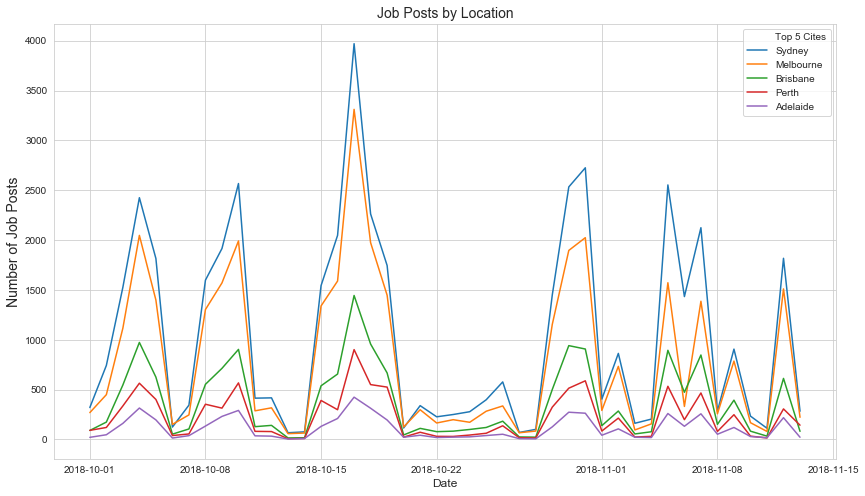

In [98]:
# 2.4 Visualise trending of the job postings for the big cities.* (2 points)

# Filter the dataset by top 5 big cities
df_topcities= df[(df['Location'].isna()==False) & (df['Location'].isin(['Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide']).astype(int))]

# Group the dataset by Date and Location, count number of job by date in each location
df_topcities = df_topcities.groupby(['Date','Location']).agg({'Id': ['count']})
df_topcities.columns = ['JobPost']
df_topcities = df_topcities.reset_index()
df_topcities = df_topcities.sort_values(by=["JobPost"], ascending =False)

# Plot the job post for different date and location
sns.set_style("whitegrid")
plt.figure (figsize=(14,8))
ax = sns.lineplot(x="Date", y="JobPost", hue="Location", data=df_topcities)

#Show all rows on print
#pd.set_option('display.max_rows', None)
#print(df_topcities.sort_values(by=["Location","Date"], ascending =True))
# Setting x, y, legend and title 
ax.legend().texts[0].set_text("Top 5 Cites")
plt.title('Job Posts by Location',size=14)
plt.ylabel('Number of Job Posts',fontsize=14)
plt.xlabel('Date',fontsize=12)



In [5]:
# 2.5 Based on the above charts, provide your observation about the number of job posts over time. Give your own conclusion.(2 points)
print('This graph prepresents weekly seasonality time-series. Every week, the peak time of job post is in the middle of the week (Wed - Thur) and the lowest job post is at the begining and the end of each week. ')
print('We can use this data to predict the number of job postings for the next 7 days using moving average method.')

This graph prepresents weekly seasonality time-series. Every week, the peak time of job post is in the middle of the week (Wed - Thur) and the lowest job post is at the begining and the end of each week. 
We can use this data to predict the number of job postings for the next 7 days using moving average method.


There are 44 days in the data set.
We were using the first 30 days to calcualte and forecast for the next 14 days. Then used the 14 actual days to test our prediction.


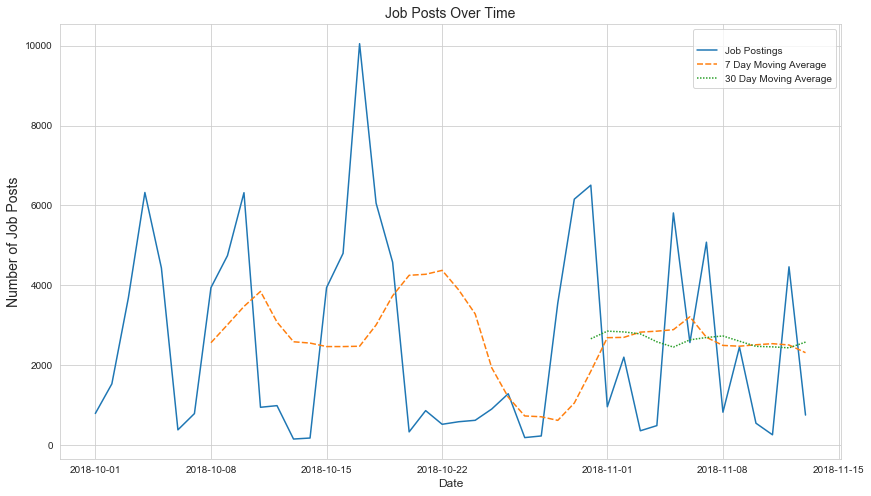

In [149]:
# 3.1 Using moving average for 7 days and 30 days to predict the number of job postings and visualise them in line chart. Which one creates a better prediction? Explain your choice.** (3 points)

import matplotlib.dates as mdates
from datetime import date, timedelta
import calendar

# Filter the dataset by top 5 big cities
df_jobpost= df[(df['Location'].isna()==False) & (df['Location'].isin(['Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide']).astype(int))]

# Group job post by date
df_jobpost = df_jobpost.groupby('Date').agg({'Id': ['count']})
df_jobpost.columns = ['JobPost']
df_jobpost = df_jobpost.reset_index()
df_jobpost = df_jobpost.sort_values(by=["Date"], ascending =True)

# Adding a a type column to store the type of data []"Actual", "4 days moving average","30 days moving average"]
df_jobpost['MA'] = "Job Postings"

# Method to return number of different days between two dates
def diff_date(start, end, dtype):
    x = pd.to_datetime(end) - pd.to_datetime(start)
    return int(x / np.timedelta64(1, dtype))


# Using moving average
def moving_average(df, k, from_date, to_date):
    origindf = df.copy()
    moving_average_df = pd.DataFrame(columns=['Date','JobPost'])
    num_df = len(origindf)
    diffDay = diff_date(from_date, to_date, 'D')
    for m in range(diffDay + 1):
        if m < k:
            dt_predict = float('nan')
        else:
            history = origindf['JobPost'][m-k:m]
            dt_predict = history.mean()
        moving_average_df.loc[m] = ['{Date.year}-{Date.month}-{Date.day}'.format(Date = from_date + pd.Timedelta(days=m)), dt_predict]
        if m >= num_df:
            origindf.loc[m]= ['{Date.year}-{Date.month}-{Date.day}'.format(Date =  from_date + pd.Timedelta(days=m)), dt_predict]
    return moving_average_df

# Start and end date of graph
sdate = date(2018, 10, 1)  
edate = date(2018, 11, 13) 

# 7 days moving average
ma_df_7Days = moving_average(df_jobpost, 7, sdate, edate)
ma_df_7Days['MA'] = "7 Day Moving Average"

# 30 days moving average 
ma_df_30Days = moving_average(df_jobpost, 30, sdate, edate)
ma_df_30Days['MA'] = "30 Day Moving Average"

# Combine of actual dataset, 7 days dataset, 30 days dataset
eval_df = pd.concat([df_jobpost,ma_df_7Days, ma_df_30Days], ignore_index=True)

# Convert Date to dateime column
eval_df['Date'] = pd.to_datetime(eval_df['Date'])

# Plot the job post for different date and location
sns.set_style("whitegrid")
plt.figure (figsize=(14,8))
ax = sns.lineplot(x="Date", y="JobPost", hue="MA", style="MA", data=eval_df)
ax.legend().texts[0].set_text("")
plt.title('Job Posts Over Time',size=14)
plt.ylabel('Number of Job Posts',fontsize=14)
plt.xlabel('Date',fontsize=12)
print('There are 44 days in the data set.')
print('We were using the first 30 days to calcualte and forecast for the next 14 days. Then used the 14 actual days to test our prediction.')
eval_df.to_csv('D:\DataAnalysis_CyberSecurity\BigData\Assessment\Assessment3\MovingAverage.csv', header=False, index=False)

In [175]:
# Using MSE to measure the average of the squares of the errors. The smaller of the MSE value, the more stable the forecast model. 

sdate = date(2018, 10, 1)  
edate = date(2018, 11, 13) 

# Using 30 first days to calculate and predict 14 days 
fIndex = 30

tIndex = len(ma_df_7Days)

MSE = (df_jobpost['JobPost'][fIndex:tIndex] - moving_average(df_jobpost, 7, sdate, edate)['JobPost'][fIndex:tIndex])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Moving average 7 days", MSE))

MSE = (df_jobpost['JobPost'][fIndex:tIndex] - moving_average(df_jobpost, 30, sdate, edate)['JobPost'][fIndex:tIndex])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Moving average 30 days", MSE))

MSE of Moving average 7 days: 4957202.967930029
MSE of Moving average 30 days: 4693413.184761904


In [101]:
# 3.2 Choose your favourite job sector/sub-sector, then use TF/IDF to extract important keywords. Visualise them in word cloud chart (hint: you can use the online tool https://wordart.com/create or similar websites)**. (3 points)
import sys

# Cleaning data before text normalization 

# Chose "Information & Communication Technology" sector
df_it = df[(df['Classification'] == "Information & Communication Technology") & (df['SubClassification'] == "Engineering - Software") & (df['Requirement'].notnull())]
df_it.head()

# This method to remove html tags from a strin
def remove_html_tags(text):
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Apply remove HTML method to the column FullDescription
df_it['Requirement'] = df_it['Requirement'].replace('nbsp', ' ', regex=True)
df_it['Requirement'] = df_it['Requirement'].apply(remove_html_tags)

#print(df_it )

In [102]:
# Normalize text by stemming, tokenizing, and removing stopwords. 
from __future__ import print_function, division
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('punkt')
import string
from nltk.corpus import stopwords
import math
from collections import Counter
nltk.download('stopwords')
import pprint 
pp = pprint.PrettyPrinter(indent=4)

def normalize(document):
    # TODO: remove punctuation
    text = "".join([ch for ch in document if ch not in string.punctuation]) #and ch not in string.digits])
    
    # TODO: tokenize text
    tokens = nltk.word_tokenize(text)
    
    # TODO: Stemming
    stemmer = PorterStemmer()
    ret = " ".join([stemmer.stem(word.lower()) for word in tokens])
    return ret

original_documents = [x.strip() for x in df_it['Requirement']] 
documents = [normalize(d).split() for d in original_documents]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [104]:
# Implement TF-IDF, including creating the vocabulary, computing term frequency, and normalizing by tf-idf weights

# Flatten all the documents
flat_list = [word for doc in documents for word in doc]

# TODO: remove stop words from the vocabulary
words = [word for word in flat_list if word not in stopwords.words('english')]

# TODO: we take the 500 most common words only
counts = Counter(words)
vocabulary = counts.most_common(500)
print([x for x in vocabulary if x[0] == 'work'])
vocabulary = [x[0] for x in vocabulary]
assert len(vocabulary) == 500

# vocabulary.sort()
vocabulary[:5]
print(vocabulary[:5])

[('work', 267)]
['engin', 'develop', 'work', 'team', 'join']


In [105]:
def tf(vocabulary, documents):
    matrix = [0] * len(documents)
    for i, document in enumerate(documents):
        counts = Counter(document)
        matrix[i] = [0] * len(vocabulary)
        for j, term in enumerate(vocabulary):
            matrix[i][j] = counts[term]
    return matrix

tf = tf(vocabulary, documents)
np.array(vocabulary)[np.where(np.array(tf[1]) > 0)], np.array(tf[1])[np.where(np.array(tf[1]) > 0)]


(array(['engin', 'join', 'softwar', 'opportun', 'senior', 'high', 'growth',
        'start', 'uniqu'], dtype='<U14'),
 array([1, 1, 1, 1, 1, 2, 1, 1, 1]))

In [106]:
print(vocabulary)

['engin', 'develop', 'work', 'team', 'join', 'softwar', 'lead', 'opportun', 'look', 'contract', 'senior', 'project', 'data', 'technolog', 'sydney', 'role', 'compani', 'build', 'product', 'cbd', 'thi', 'requir', 'platform', 'month', 'base', 'experi', 'system', 'seek', 'excit', 'client', 'organis', 'global', 'cloud', 'solut', 'aw', 'grow', 'java', 'devop', 'servic', 'experienc', 'c', 'great', 'busi', 'tech', 'design', 'full', 'stack', 'new', 'one', 'applic', 'technic', '6', 'support', 'across', 'net', 'manag', 'high', 'growth', 'innov', 'australia', 'end', 'consult', 'within', 'strong', 'skill', 'passion', 'custom', 'posit', 'environ', 'digit', 'use', 'larg', 'talent', 'startup', 'melbourn', 'locat', 'help', 'australian', 'start', 'web', 'deliv', 'big', 'program', 'secur', 'transform', 'industri', 'front', 'want', 'provid', 'need', 'specialist', 'perman', 'level', 'world', 'current', 'integr', 'autom', 'fintech', 'enterpris', 'excel', 'multipl', 'javascript', 'career', 'agil', 'initi', '

In [138]:
def idf(vocabulary, documents):
    """TODO: compute IDF, storing values in a dictionary"""
    idf = {}
    num_documents = len(documents)
   
    for i, term in enumerate(vocabulary):
        idf[term] = math.log(num_documents / sum(term in document for document in documents), 2)
    return idf

idf = idf(vocabulary, documents)
[idf[key] for key in vocabulary[:5]]

[1.5902811981401381,
 1.6349251131949802,
 2.114592671076537,
 2.4137108830558134,
 2.385696506886217]

In [135]:
def vectorize(document, vocabulary, idf):
    vector = [0]*len(vocabulary)
    counts = Counter(document)
    for i,term in enumerate(vocabulary):
        vector[i] = idf[term] * counts[term]
    return vector

document_vectors = [vectorize(s, vocabulary, idf) for s in documents]
np.array(vocabulary)[np.where(np.array(document_vectors[1]) > 0)], np.array(document_vectors[1])[np.where(np.array(document_vectors[1]) > 0)]


(array(['engin', 'join', 'softwar', 'opportun', 'senior', 'high', 'growth',
        'start', 'uniqu'], dtype='<U14'),
 array([1.5902812 , 2.38569651, 2.49367919, 2.75521935, 3.16727299,
        9.12514854, 4.50117372, 5.04174211, 6.62670461]))

In [180]:
# Get the top 50 common words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english', max_features=500)

features = tfidf.fit(original_documents)
corpus_tf_idf = tfidf.transform(original_documents) 

sum_words = corpus_tf_idf.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in tfidf.vocabulary_.items()]

top50_common_words = sorted(words_freq, key = lambda x: x[1], reverse=True)[:100]

# Generate dataframe from list top 50 common words and write to xlsx.
pd.DataFrame(top50_common_words).to_csv('D:\DataAnalysis_CyberSecurity\BigData\Assessment\Assessment3\wordart' + pd.datetime.now().strftime("%d-%b-%Y%H-%M-%S") + '.csv', header=False, index=False)

# Import the csv to Word Art to create the Work Art
print(top50_common_words)
print('engineer', corpus_tf_idf[1, features.vocabulary_['engineer']])

[('engineer', 47.001446580595456), ('software', 43.08739959562446), ('join', 40.97448814102951), ('developer', 39.63435040028066), ('team', 39.449187560022246), ('work', 39.41385696849622), ('opportunity', 32.12002183042886), ('senior', 31.57175459629456), ('looking', 31.2440107900794), ('contract', 31.045100981108114), ('data', 28.966417606498972), ('sydney', 26.83095312585015), ('development', 26.206797111357094), ('leading', 24.436760350090122), ('role', 23.5123940641226), ('technology', 23.0155118028241), ('company', 22.678206408143303), ('cbd', 22.228546837053962), ('lead', 21.761358859240072), ('experience', 21.320956634418636), ('engineers', 21.017395510085098), ('month', 20.831405841767477), ('exciting', 20.64453922265378), ('based', 20.378759254807733), ('cloud', 19.68936298257434), ('java', 19.53846865730311), ('devops', 19.1984266512124), ('organisation', 19.161203361650678), ('working', 19.072368083996516), ('experienced', 18.51085057884949), ('stack', 18.24126092136229), (

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [203]:
# Apply TF-IDF for information retrieval
def cosine_similarity(v1,v2):
    """TODO: compute cosine similarity"""
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range (len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxy == 0:
        result = 0
    else:
        result = sumxy/math.sqrt(sumxx*sumyy)
    return result

def search_vec(query, k, vocabulary, stemmer, document_vectors, original_documents):
    q = query.split()
    q = [stemmer.stem(w) for w in q]
    query_vector = vectorize(q, vocabulary, idf)
    
    # TODO: rank the documents by cosine similarity
    scores = [[cosine_similarity(query_vector, document_vectors[d]),d] for d in range(len(document_vectors))]
    scores.sort(key=lambda x: -x[0])
    
    print('Top-{0} documents'.format(k))
    for i in range(k):
        print("********************------ " + repr(i+1) + " -------********************")
        print(repr(i+1) + ") ", original_documents[scores[i][1]])

query = "team recuit"
stemmer = PorterStemmer()
search_vec(query, 5, vocabulary, stemmer, document_vectors, original_documents)


Top-5 documents
********************------ 1 -------********************
1)  Join our growing team!
********************------ 2 -------********************
2)  Our Global Platform Service team is looking for an experienced Senior Software Engineer to join the team.
********************------ 3 -------********************
3)  Software Engineer We are seeking an experienced Software Engineer in our Product Development team. You’ll be working with a top team of talented profe
********************------ 4 -------********************
4)  Sophisticated sports data and analytics team with global reach seek two experienced engineers to join their growing Sydney team.
********************------ 5 -------********************
5)  Seeking a Senior Developer to join one of our most exciting product teams. Lead the team and have a direct impact as we scale


5637


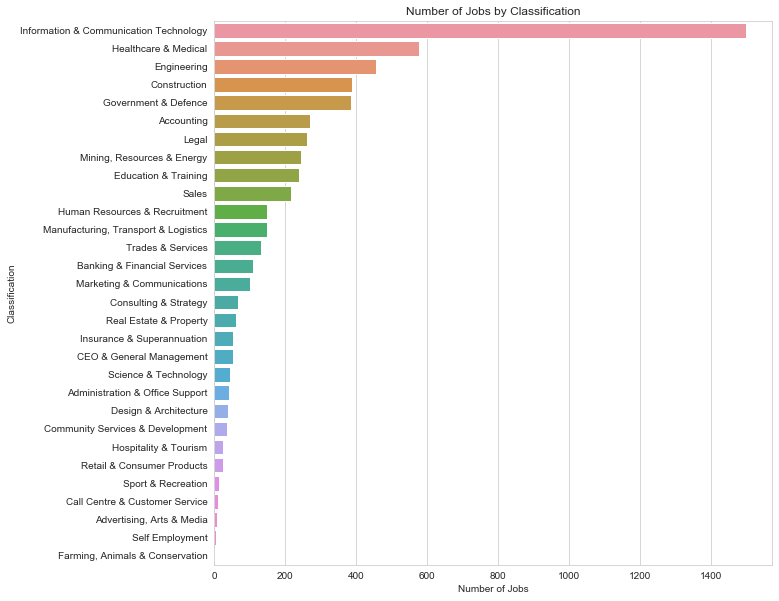

Text(3.925000000000008, 0.5, 'Highest Salary')

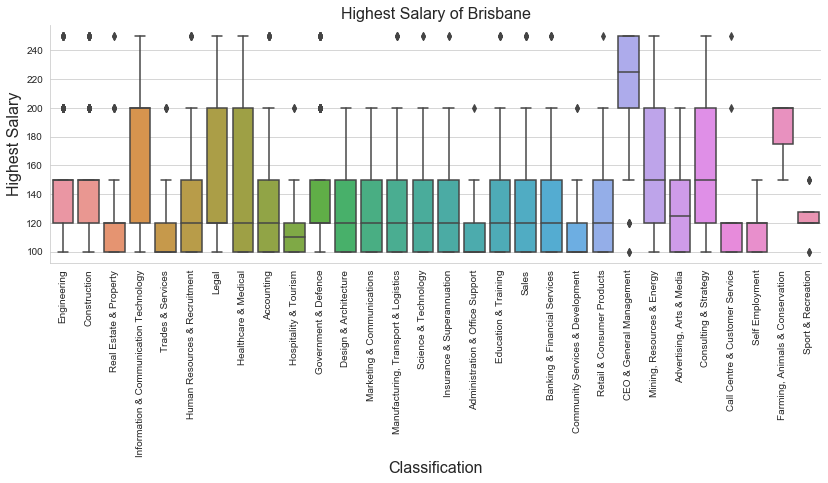

In [255]:
#Section 2
#Scenario 1
# Finding major and subject to suggest Tom (Good income ( >= 80K ) and guarantee a job in QLD)

df_b = df[(df['Location'] == "Brisbane") & (df['LowestSalary'] >= 80) & (df['Classification'].notnull()) & (df['SubClassification'].notnull())]
print (len(df_b.index))

# Which classification has the top job posts
plt.figure(figsize=(10,10))
sns.countplot(y='Classification',data=df_b, order=df_b.Classification.value_counts().index)
plt.title('Number of Jobs by Classification')
plt.xlabel('Number of Jobs')
plt.show()

# Salary range in each classification
ax = sns.catplot(x="Classification", y="HighestSalary", data = df_b, kind="box", height=4, aspect=3)
ax.set_xticklabels(rotation=90)
plt.title('Highest Salary of Brisbane',size=16,loc='center')
plt.xlabel('Classification',size=16)
plt.ylabel('Highest Salary',size=16)




#print(df_b.Classification.value_counts())


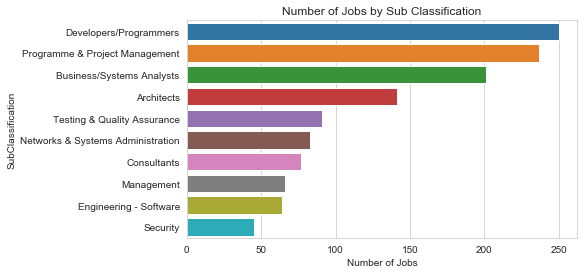

Text(3.925000000000008, 0.5, 'Highest Salary')

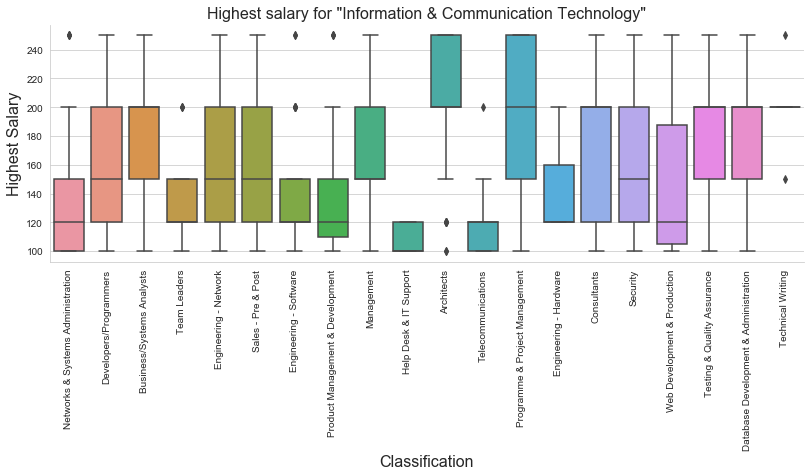

In [257]:
df_bc = df_b[(df_b['Classification'] == "Information & Communication Technology") & (df_b['SubClassification'] != "Other")]

# Top 10 sub classification which have top job posts
plt.figure(figsize=(7,4))
sns.countplot(y='SubClassification',data=df_bc,  order=df_bc.SubClassification.value_counts().iloc[:10].index)
plt.title('Number of Jobs by Sub Classification')
plt.xlabel('Number of Jobs')
plt.show()

# Salary range in each sub classification
ax = sns.catplot(x="SubClassification", y="HighestSalary", data = df_bc, kind="box", height=4, aspect=3)
ax.set_xticklabels(rotation=90)
plt.title('Highest salary for "Information & Communication Technology"',size=16,loc='center')
plt.xlabel('Classification',size=16)
plt.ylabel('Highest Salary',size=16)

